In [119]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pinot
import torch
from matplotlib import pyplot as plt
import numpy as np
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
ds = pinot.data.esol()

ds = pinot.data.utils.batch(ds, len(ds))

g_all, y_all = ds[0]



In [144]:
y_all.max()

tensor(1.5800)

In [140]:
xss = []

for _ in range(10):
    
    net = pinot.Net(
        representation=pinot.representation.Sequential(
            layer=pinot.representation.dgl_legacy.gn(),
            config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
            output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

    optimizer = torch.optim.Adam(net.parameters(), 1e-3)

    acquisition = pinot.active.acquisition.probability_of_improvement

    bo = pinot.active.experiment.BayesOptExperiment(
        net=net,
        acquisition=acquisition,
        q=96,
        optimizer=optimizer,
        data=ds[0],
        slice_fn=pinot.active.experiment._slice_fn_tuple, # pinot.active.
        collate_fn=pinot.active.experiment._collate_fn_graph, # pinot.active.
        n_epochs=10,
        )
    
    xs = []
    
    num_rounds = 4

    idx = 0
    bo.blind_pick(seed=None)
    bo.update_data()

    while idx < num_rounds:
        bo.train()
        bo.acquire()
        bo.update_data()


        x = pinot.active.acquisition.probability_of_improvement(
            pinot.metrics._independent(bo.net.condition(g_all)),
            y_best=bo.y_best).max().detach().numpy()

        print(x)
        
        xs.append(x)
        

        idx += 1
        
    print('---')
        
    xss.append(xs)



0.05912459
0.31377012
0.2793941
0.30384213
---
0.595913
0.058745027
0.28064406
0.2935332
---
0.05912459
0.20875454
0.2314204
0.2650736
---
0.595913
0.03831762
0.236866
0.2586658
---
0.05912459
0.25811052
0.20643628
0.20909697
---
0.595913
0.05874282
0.32018828
0.26863062
---
0.05912459
0.28509218
0.23477387
0.21221143
---
0.21591675
0.056756377
0.3014692
0.28458375
---
0.05796194
0.20488054
0.22583103
0.29065537
---
0.6583463
0.058467746
0.27395117
0.18114811
---


In [141]:
xss = np.array(xss)

In [142]:
xss

array([[0.05912459, 0.31377012, 0.2793941 , 0.30384213],
       [0.595913  , 0.05874503, 0.28064406, 0.2935332 ],
       [0.05912459, 0.20875454, 0.2314204 , 0.2650736 ],
       [0.595913  , 0.03831762, 0.236866  , 0.2586658 ],
       [0.05912459, 0.25811052, 0.20643628, 0.20909697],
       [0.595913  , 0.05874282, 0.32018828, 0.26863062],
       [0.05912459, 0.28509218, 0.23477387, 0.21221143],
       [0.21591675, 0.05675638, 0.3014692 , 0.28458375],
       [0.05796194, 0.20488054, 0.22583103, 0.29065537],
       [0.6583463 , 0.05846775, 0.27395117, 0.18114811]], dtype=float32)

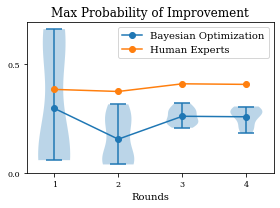

In [143]:
plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig, ax = plt.subplots(figsize=(4, 3))

cmap=plt.get_cmap('tab10')


ax.violinplot(
    xss)

ax.plot(
    [1, 2, 3, 4],
    xss.mean(axis=0),
    label='Bayesian Optimization',
    color=cmap(0),
    marker='o')

ax.plot(
    [1, 2, 3, 4],
    [
0.38230854,
0.37273157,
0.4078949,
0.4052515

    ],

marker='o',
    
label='Human Experts'
    
)

ax.legend()

ax.set_xticks([1, 2, 3, 4])
ax.set_yticks([0.0, 0.5])

ax.set_xlabel('Rounds')
ax.set_title(r'Max Probability of Improvement')
# ax.set_ylabel('Inhibition @ 20 uM')

# ax.set_ylabel('Probability of Improvement')

plt.tight_layout()
# plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('us_vs_human_pi.png', dpi=500)

In [ ]:
plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig, ax = plt.subplots(figsize=(4, 3))

cmap=plt.get_cmap('tab10')



for q_idx, q in enumerate([12, 24, 48, 96]):
    xss = []
    
    num_rounds = int(96 * 4 / q)

    for _ in range(5):

        net = pinot.Net(
            representation=pinot.representation.Sequential(
                layer=pinot.representation.dgl_legacy.gn(),
                config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
                output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

        optimizer = torch.optim.Adam(net.parameters(), 1e-3)

        acquisition = pinot.active.acquisition.probability_of_improvement

        bo = pinot.active.experiment.BayesOptExperiment(
            net=net,
            acquisition=acquisition,
            q=q,
            optimizer=optimizer,
            data=ds[0],
            slice_fn=pinot.active.experiment._slice_fn_tuple, # pinot.active.
            collate_fn=pinot.active.experiment._collate_fn_graph, # pinot.active.
            n_epochs=1,
            )

        xs = []

        idx = 0
        bo.blind_pick(seed=None)
        bo.update_data()

        while idx < num_rounds:
            bo.train()
            bo.acquire()
            bo.update_data()


            x = pinot.active.acquisition.probability_of_improvement(
                pinot.metrics._independent(bo.net.condition(g_all)),
                y_best=bo.y_best).max().detach().numpy()

            print(x)

            xs.append(x)


            idx += 1

        print('---')

        xss.append(xs)


    xss = np.array(xss)
        
    ax.violinplot(
        dataset=xss,
        positions=[q * (idx_+1) for idx_ in range(num_rounds)],
        widths=10)

    ax.plot(
        [q * (idx_+1) for idx_ in range(num_rounds)],
        xss.mean(axis=0),
        label='q=%s' % q,
        color=cmap(q_idx),
        marker='o')
    
    ax.legend()
    

plt.xlabel('Number of Candidates Acquired')
plt.ylabel('Max Probability of Improvement')

plt.savefig('batch_size.png', dpi=500)


0.5398078
0.5397898
0.054371357
0.08718324
0.089930534
0.086435914
0.07673466
0.08019972
0.09059727
0.109475136
0.1373359
0.1709665
0.20265365
0.22976363
0.25074303
0.26309305
0.2719593
0.27134752


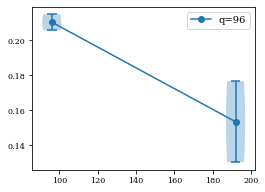

In [159]:

fig, ax = plt.subplots(figsize=(4, 3))
xss = np.array(xss)

ax.violinplot(
    dataset=xss,
    positions=[q * (idx_+1) for idx_ in range(num_rounds)],
    widths=10)

ax.plot(
    [q * (idx_+1) for idx_ in range(num_rounds)],
    xss.mean(axis=0),
    label='q=%s' % q,
    color=cmap(0),
    marker='o')

ax.legend()

In [153]:
xss

array([[0.2148804 , 0.13029253],
       [0.20567   , 0.17669177]], dtype=float32)